In [1]:
import os
import sys
from decimal import Decimal

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import measure

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
from m2py.utils import config
from m2py.utils import pre_processing as pre
from m2py.utils import post_processing as post
from m2py.utils import seg_label_utils as slu
from m2py.segmentation import segmentation_gmm as seg_gmm
from m2py.segmentation import segmentation_watershed as seg_water

# Data intake and label generation

In [ ]:
lit_files = '/Users/wesleytatum/Dropbox/SSTS_files/Manuscript/data_files/'

im1_opv = np.load(lit_files+'175C_30min_Sub8_Dev8.npy')
im3_annealed = np.load(lit_files+'P3HT-PCBM_150C_15min_sub2.npy')
im5_PTB7 = np.load(lit_files+'PTB7PC71BM_CBonly_ascast_fresh_500 nm_combined.npy')
im6_OFET = np.load(lit_files+'150C_30min_8_3_combined.npy')
im7_NWs = np.load(lit_files+'100-0_72_NW_combined.npy')
cafm = np.load(lit_files+'WT2-97_cafm.npy')
amfm = np.load(lit_files+'WT2-107_amfm_90.npy')

ims = [im1_opv, im3_annealed, im5_PTB7, im6_OFET, im7_NWs, cafm, amfm]

In [ ]:
def m2py_pipeline(dataframe, heightless, outlier_threshold, n_components, padding, embedding_dim, thresh, nonlinear, normalize, zscale, data_type, data_subtype, input_cmap):
    """
    Wrapper function for m2py tools. Allows to include or exclude m2py tools in the order shown in the code.
    
    Args:
    dataframe - np.array(). 3D array of SPM data
    heightless - bool. if 'True', height channel is removed. Height is assumed to be dataframe[:,:,4]
    n_components - int. number specifying the number of Gaussian phase distributions to be identified in dataframe
    padding - int. number specifying the degree of closeness of neighbors to be included in GMM labelling
    embedding_dims - int. number specifying the number of principle components to use in PCA before GMM labelling
    nonlinear - bool. if 'True', nonlinear properties are generated prior to analysis. Includes x^2, x^3, abs(x),
                and 1/x
                
    Returns:
    outliers - np.array(). 2D array of outliers
    seg1_labels - np.array(). 2D array of GMM labels
    seg2_labels - np.array(). 2D array of clustering labels
    """
  
    fill_zeros_flag = True
    remove_outliers_flag = True
    input_cmap = input_cmap
    
    # Apply frequency removal
    data = pre.apply_frequency_removal(dataframe, data_type)
    
    data_properties = config.data_info[data_type]['properties']

    # Extract outliers
    outliers = pre.extract_outliers(data, data_type, threshold = outlier_threshold)
    no_outliers_data = pre.smooth_outliers_from_data(data, outliers)
    
    pre.show_outliers(dataframe, data_type, outliers)

    # Show a-priori distributions
    pre.show_property_distributions(data, data_type, outliers)

    c = data.shape[2]
    num_pca_components = min(embedding_dim, c)
    
    # Run GMM segmentation
    seg1 = seg_gmm.SegmenterGMM(n_components = n_components, embedding_dim = num_pca_components, padding = padding,
                                nonlinear = nonlinear, normalize=normalize, zscale=zscale)

    if heightless == True:
        # Remove height property
        height_id = data_properties.index("Height")
        
        no_height_data = np.delete(no_outliers_data, height_id, axis=2)

        seg1_labels = seg1.fit_transform(no_height_data, outliers)
        
        if fill_zeros_flag:
            seg1_labels = slu.fill_out_zeros(seg1_labels, outliers)

        elif remove_outliers_flag:
            seg1_labels = np.ma.masked_where(outliers == 1, pre_labels)

        post.show_classification(seg1_labels, no_height_data, data_type)
        post.show_classification_correlation(seg1_labels, no_height_data, data_type)
        post.show_distributions_together(seg1_labels, no_height_data, data_type, input_cmap = 'jet')
        post.show_grain_area_distribution(seg1_labels, data_type, data_subtype)

        # Overlay distributions on pixels
        probs = seg1.get_probabilities(no_height_data)
        post.show_overlaid_distribution(probs, no_height_data, data_type)
        
        if embedding_dim != None:
            h, w, c = no_height_data.shape

            pca_components = seg1.get_pca_components(no_height_data)
            pca_components = pca_components.reshape(h, w, num_pca_components)
            post.show_classification_correlation(seg1_labels, pca_components, data_type, title_flag=False)

            post.show_classification_distributions(seg1_labels, pca_components, data_type, title_flag=False)

        else:
            pass
            
#         X = np.ravel(seg1_labels)
#         for i in range(5):
#             Y = np.ravel(no_height_data[:,:,i])
#             plt.scatter(X, Y, s = 50, marker = 'o', color = 'r', alpha = 0.1)
#             plt.ticklabel_format(style = 'sci')
#             plt.ylim((Y.min()-Y.min()*0.5), (Y.max()+Y.max()*0.1))
#             plt.show()

## Persistence Watershed Segmentation clustering
    
        if thresh != None:
        
            seg2 = seg_water.SegmenterWatershed()
            height_id = data_properties.index("Height")
            height_data = data[:, :, height_id]
            thresh = thresh

            seg2_labels = seg2.fit_transform(height_data, outliers, thresh)
                    
    # Instance segmentation (using persistence watershed) combined with gmm segmentation
            seg2_labels[seg1_labels == 1] = np.max(seg2_labels) + 1 # map background label of gmm to next pws label
            for l in np.unique(seg2_labels): # clean up small pws labels
                if np.sum(seg2_labels == l) < 2000:
                    seg2_labels = slu.fill_out_zeros(seg2_labels, seg2_labels == l)

            seg2_labels = slu.get_significant_labels(seg2_labels, bg_contrast_flag=True)
            post.show_classification(seg2_labels, no_height_data, data_type)

## Conected-components clustering
        else:
            post_labels = seg1.get_grains(seg1_labels)
            seg2_labels = slu.get_significant_labels(post_labels, bg_contrast_flag=True)

        post.show_classification(seg2_labels, no_height_data, data_type, input_cmap = input_cmap)
        post.show_grain_area_distribution(seg2_labels, data_type, data_subtype)
        
#         X = np.ravel(seg2_labels)
#         for i in range(5):
#             Y = np.ravel(no_height_data[:,:,i])
#             plt.scatter(X, Y, s = 50, marker = 'o', color = 'r', alpha = 0.1)
#             plt.ticklabel_format(style = 'sci')
#             plt.ylim((Y.min()-Y.min()*0.5), (Y.max()+Y.max()*0.1))
#             plt.show()

        
    elif heightless == False:
        
        seg1_labels = seg1.fit_transform(no_outliers_data, outliers)
        
        if fill_zeros_flag:
            seg1_labels = slu.fill_out_zeros(seg1_labels, outliers)

        elif remove_outliers_flag:
            seg1_labels = np.ma.masked_where(outliers == 1, pre_labels)

        post.show_classification(seg1_labels, no_outliers_data, data_type)
        post.show_distributions_together(seg1_labels, no_outliers_data, data_type, input_cmap = input_cmap)

        post.show_classification(seg1_labels, no_outliers_data, data_type)
        post.show_classification_correlation(seg1_labels, no_outliers_data, data_type)
        post.show_distributions_together(seg1_labels, no_outliers_data, data_type, input_cmap = input_cmap)

        # Overlay distributions on pixels
        probs = seg1.get_probabilities(no_outliers_data)
        post.show_overlaid_distribution(probs, no_outliers_data, data_type)
        post.show_grain_area_distribution(seg1_labels, data_type, data_subtype)
        
        
        if embedding_dim != None:
            h, w, c = no_outliers_data.shape

            pca_components = seg1.get_pca_components(no_outliers_data)
            pca_components = pca_components.reshape(h, w, num_pca_components)
            post.show_classification_correlation(seg1_labels, pca_components, data_type, title_flag=False)

            post.show_classification_distributions(seg1_labels, pca_components, data_type, title_flag=False)

            
        else:
            pass
            
#         X = np.ravel(seg1_labels)
#         for i in range(6):
#             Y = np.ravel(no_outliers_data[:,:,i])
#             plt.scatter(X, Y, s = 50, marker = 'o', color = 'r', alpha = 0.1)
#             plt.ticklabel_format(style = 'sci')
#             plt.ylim((Y.min()-Y.min()*0.5), (Y.max()+Y.max()*0.1))
#             plt.show()
        
## Persistence Watershed Segmentation clustering
    
        if thresh != None:
        
            seg2 = seg_water.SegmenterWatershed()
            height_id = data_properties.index("Height")
            height_data = data[:, :, height_id]
            thresh = thresh

            seg2_labels = seg2.fit_transform(height_data, outliers, thresh)
            
    # Instance segmentation (using persistence watershed) combined with gmm segmentation
            seg2_labels[seg1_labels == 1] = np.max(seg2_labels) + 1 # map background label of gmm to next pws label
            for l in np.unique(seg2_labels): # clean up small pws labels
                if np.sum(seg2_labels == l) < 2000:
                    seg2_labels = slu.fill_out_zeros(seg2_labels, seg2_labels == l)

            seg2_labels = slu.get_significant_labels(seg2_labels, bg_contrast_flag=True)
            post.show_classification(seg2_labels, no_outliers_data, data_type)

## Conected-components clustering
        else:
            post_labels = seg1.get_grains(seg1_labels)
            seg2_labels = slu.get_significant_labels(post_labels, bg_contrast_flag=True)
        
        post.show_classification(seg2_labels, no_outliers_data, data_type, input_cmap = input_cmap)
        post.show_grain_area_distribution(seg2_labels, data_type, data_subtype)

#         X = np.ravel(seg2_labels)
#         for i in range(6):
#             Y = np.ravel(no_outliers_data[:,:,i])
#             plt.scatter(X, Y, s = 50, marker = 'o', color = 'r', alpha = 0.1)
#             plt.ticklabel_format(style = 'sci')
#             plt.ylim((Y.min()-Y.min()*0.5), (Y.max()+Y.max()*0.1))
#             plt.show()
        
    else:
        print ('Error: Heightless flag incorrect')
    
    return outliers, seg1_labels, seg2_labels

In [ ]:
# ims = [im1_opv, im3_annealed, im5_PTB7, im6_OFET, im7_NWs, cafm, amfm]
ims = [im1_opv]
n_components = [2]
heightless = [False]
outlier_threshold = [2.5]
padding = 0
embedding_dim = 4
thresh = None     ## Persistence Watershed Threshold
nonlinear = True
normalize = True
zscale = False
data_type = ['QNM']
data_subtype = ['Backgrounded']
input_cmap = ['jet']

seg1_dict = {}    
seg2_dict = {}

p_stats = {}
g_stats = {}

phases = {}
grains = {}
correlated_labels = {}

h = 0
for h, im in enumerate(ims):
    outliers, seg1_labels, seg2_labels = m2py_pipeline(im, heightless = heightless[h],
                                                          n_components = n_components[h],
                                                          outlier_threshold = outlier_threshold[h],
                                                          padding = padding,
                                                          embedding_dim = embedding_dim,
                                                          thresh = thresh,
                                                          nonlinear = nonlinear,
                                                          normalize = normalize,
                                                          zscale = zscale,
                                                          data_type = data_type[h],
                                                          data_subtype = data_subtype[h],
                                                          input_cmap = input_cmap[h])
    
    print (f'-----------{h}---------------------------------')
    print (f'--------------------{h}------------------------')
    print (f'-----------------------------{h}---------------')
    
    seg1_dict[h] = seg1_labels
    seg2_dict[h] = seg2_labels
    
#     p_stats[h] = get_stats_dict(seg1_labels, im)
#     g_stats[h] = get_stats_dict(seg2_labels, im)
    
#     phases[h] = slu.phase_sort(im, seg1_labels, n_components)
#     grains[h] = slu.grain_sort(im, seg2_labels)
    
#     correlated_labels[h] = label_comparison(seg1_labels, seg2_labels)

# Extract semantic and instance segmentation labels

In [ ]:
phase_labels = seg1_labels
grain_labels = seg2_labels

x,y = phase_labels.shape
print (x,y)

# Compare pixel count for 2 phases

In [ ]:
phase1 = np.asarray([label for label in phase_labels == 1])
phase2 = np.asarray([label for label in phase_labels == 2])

In [ ]:
phase1_count = 0
phase2_count = 0

for i in range(x):
    for j in range(y):
        if phase1[i,j] == True:
            phase1_count+=1
        elif phase2[i,j] == True:
            phase2_count+=1
        else:
            pass

In [ ]:
print (phase1_count, phase2_count)
print ('phase1 = ', phase1_count/(phase1_count+phase2_count), ' %')
print ('phase2 = ', phase2_count/(phase1_count+phase2_count), ' %')

# Access pixels for a single arbitrary grain

In [ ]:
grain_count = grain_labels.max()

print (grain_count)

In [ ]:
grain = np.asarray([label for label in grain_labels == 2])
grain = grain.astype(int)
# print (grain)
plt.imshow(grain)

In [ ]:
def resize_boundaries(grain):
    
    x,y = grain.shape
    left_edge = y
    right_edge = 0
    top_edge = x
    bottom_edge = 0
    
    for i in range(x):
        for j in range(y):
            if grain[i,j] == True:
                if j < left_edge:
                    left_edge = j
                elif j > right_edge:
                    right_edge = j
                else:
                    pass

                if i < top_edge:
                    top_edge = i
                elif i > bottom_edge:
                    bottom_edge = i
                else:
                    pass

            else:
                pass
            
    if left_edge == 0:
        left_edge = 1
    else:
        pass
    if right_edge == y:
        right_edge = y-1
    else:
        pass
    if top_edge == 0:
        top_edge = 1
    else:
        pass
    if bottom_edge == x:
        bottom_edge = x-1
    else:
        pass
            
#     print (left_edge, right_edge, top_edge, bottom_edge)

    return np.asarray(grain[(top_edge-1):(bottom_edge+2), (left_edge-1):(right_edge+2)])

In [ ]:
resized_grain = resize_boundaries(grain)
# print (resized_grain.shape)
plt.imshow(resized_grain)

In [ ]:
def all_domain_properties(grain_labels):
    
    all_props = {}
    
    grain_count = int(grain_labels.max())
    
    for i in range(2, grain_count+1):
#         print (i)
    
        grain = np.asarray([label for label in grain_labels == i])
        grain = grain.astype(int)
        resized_grain = resize_boundaries(grain)
        props_table = measure.regionprops_table(resized_grain, properties = ['label', 'major_axis_length','minor_axis_length',
                                                                             'eccentricity', 'orientation', 'perimeter'])
        props_table['label'] = i
    
        all_props[i] = props_table
        
    props_df = pd.DataFrame.from_dict(all_props, orient = 'index')
    
    return props_df

In [ ]:
test = all_domain_properties(grain_labels)

In [ ]:
print (test)

In [ ]:
def plot_descriptors(descriptor_dict):

    fig = plt.figure(figsize = (12,8))

    ax = fig.add_subplot(2,3,1)
    plt.scatter(descriptor_dict['label'], descriptor_dict['major_axis_length'])
    ax.set_title('major_axis_length')

    ax = fig.add_subplot(2,3,2)
    plt.scatter(descriptor_dict['label'], descriptor_dict['minor_axis_length'])
    ax.set_title('minor_axis_length')

    ax = fig.add_subplot(2,3,3)
    plt.scatter(descriptor_dict['label'], descriptor_dict['perimeter'])
    ax.set_title('perimeter')

    ax = fig.add_subplot(2,3,4)
    plt.scatter(descriptor_dict['label'], descriptor_dict['orientation'])
    ax.set_title('orientation')

    ax = fig.add_subplot(2,3,5)
    plt.scatter(descriptor_dict['label'], descriptor_dict['eccentricity'])
    ax.set_title('eccentricity')

    plt.tight_layout()
    plt.show()

In [ ]:
plot_descriptors(test)

In [2]:
map_file_path = '/Volumes/Tatum_SSD-1/Grad_School/m2py/Morphology_labels/OFET_morph_maps/Default_params/'
files = os.listdir(map_file_path)
print (len(files))
print (files)

seg1_fl_list = []
seg2_fl_list = []

seg1_dict = {}
seg2_dict = {}

for fl in files:
    if fl[-5] == '1':
        seg1_fl_list.append(fl)
    elif fl[-5] == '2':
        seg2_fl_list.append(fl)
    else:
        print(fl[:-4], ' is messed up')

for k, fl in enumerate(seg1_fl_list):
    seg1_dict[k] = np.load(map_file_path+fl)
    
for k, fl in enumerate(seg2_fl_list):
    seg2_dict[k] = np.load(map_file_path+fl)

75
['100C_10min_3_1_domain_metrics.csv', '100C_10min_3_1_seg1.npy', '100C_10min_3_1_seg2.npy', '100C_10min_3_3_seg1.npy', '100C_10min_3_3_seg2.npy', '100C_10min_3_5-1_seg1.npy', '100C_10min_3_5-1_seg2.npy', '100C_10min_3_5_seg1.npy', '100C_10min_3_5_seg2.npy', '100C_10min_4_3_seg1.npy', '100C_10min_4_3_seg2.npy', '100C_15min_6_4-1_seg1.npy', '100C_15min_6_4-1_seg2.npy', '100C_15min_6_5_seg1.npy', '100C_15min_6_5_seg2.npy', '100C_30min_8_1_seg1.npy', '100C_30min_8_1_seg2.npy', '100C_30min_8_2_seg1.npy', '100C_30min_8_2_seg2.npy', '100C_30min_8_5_seg1.npy', '100C_30min_8_5_seg2.npy', '100C_5min_2_1_seg1.npy', '100C_5min_2_1_seg2.npy', '100C_5min_2_2_seg1.npy', '100C_5min_2_2_seg2.npy', '125C_10min_3_1_seg1.npy', '125C_10min_3_1_seg2.npy', '125C_10min_4_2_seg1.npy', '125C_10min_4_2_seg2.npy', '125C_10min_4_5_seg1.npy', '125C_10min_4_5_seg2.npy', '125C_15min_5_3_seg1.npy', '125C_15min_5_3_seg2.npy', '125C_15min_5_4_seg1.npy', '125C_15min_5_4_seg2.npy', '125C_15min_6_5_seg1.npy', '125C_15mi

In [10]:
all_props = {}
domain_labels = slu.relabel(seg2_dict[1])
phase_labels = seg1_dict[1]
    
domain_count = int(domain_labels.max())
print (domain_count)

unique_labes = slu.get_unique_labels(domain_labels)
unique_labes.sort()
print (unique_labes)

for i in range(2, domain_count+1):
    domain = np.asarray([label for label in domain_labels == i])
    
    #convert bool to int
    domain = domain.astype(int)

    #Check phase of pixels in the domain
    phase = phase_labels[domain == 1]
    phase_mode, count = stats.mode(phase, axis = None)
    
    domain_pixel_count = np.count_nonzero(domain == 1)
    print (f"domain {i} has {domain_pixel_count} pixels")

    if domain_pixel_count > 1:
#         resized_domain = slu.resize_boundaries(domain)
        props_table = measure.regionprops_table(domain, properties = ['label','area',
                                                                      'filled_area',
                                                                      'extent',
                                                                      'major_axis_length',
                                                                      'minor_axis_length',
                                                                      'eccentricity',
                                                                      'orientation',
                                                                      'perimeter'])
        props_table['label'] = phase_mode[0]
        
    elif domain_pixel_count <= 1:
        props_table = {'label':int(phase_mode), 'major_axis_length':1,'minor_axis_length':1,
                                    'eccentricity':0, 'orientation':0, 'perimeter':1}

    else:
        pass

#     Pass domain stats to proper phase's k:v pair
    all_props[i] = (props_table)

props_df = pd.DataFrame.from_dict(all_props, orient = 'index', dtype = 'float64')

1568
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 22

In [11]:
props_df.head()

,label,major_axis_length,minor_axis_length,eccentricity,orientation,perimeter
2,2.0,20.410003,15.484340,0.651482,-0.158986,75.526912
3,1.0,18.240320,13.883198,0.648603,1.117666,65.213203
4,2.0,16.477634,14.029611,0.524462,-0.159421,58.526912
5,2.0,18.125423,10.768740,0.804374,-1.329545,49.556349
6,2.0,21.557651,11.744514,0.838569,1.237839,66.491378


In [5]:
for i in range(1, len(slu.get_unique_labels(domain_labels))):
    count = 0
    count = np.count_nonzero(domain_labels == i)
    print (f"domain {i} has {count} pixels")

domain 1 has 5043 pixels
domain 2 has 183 pixels
domain 3 has 176 pixels
domain 4 has 168 pixels
domain 5 has 148 pixels
domain 6 has 147 pixels
domain 7 has 138 pixels
domain 8 has 135 pixels
domain 9 has 135 pixels
domain 10 has 131 pixels
domain 11 has 130 pixels
domain 12 has 130 pixels
domain 13 has 129 pixels
domain 14 has 128 pixels
domain 15 has 126 pixels
domain 16 has 126 pixels
domain 17 has 126 pixels
domain 18 has 124 pixels
domain 19 has 123 pixels
domain 20 has 121 pixels
domain 21 has 120 pixels
domain 22 has 120 pixels
domain 23 has 120 pixels
domain 24 has 117 pixels
domain 25 has 117 pixels
domain 26 has 116 pixels
domain 27 has 116 pixels
domain 28 has 113 pixels
domain 29 has 113 pixels
domain 30 has 113 pixels
domain 31 has 112 pixels
domain 32 has 112 pixels
domain 33 has 111 pixels
domain 34 has 111 pixels
domain 35 has 111 pixels
domain 36 has 110 pixels
domain 37 has 109 pixels
domain 38 has 107 pixels
domain 39 has 107 pixels
domain 40 has 107 pixels
domain 4

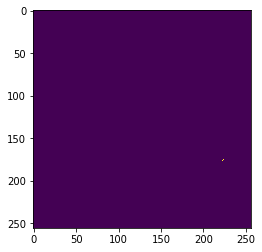

In [9]:
domain = np.asarray([label for label in domain_labels == 1551]) # looks like there are a lot of domains w/o pixels in them. Why is that?
domain = domain.astype(int)

new_im = slu.resize_boundaries(domain)
plt.imshow(domain)

In [ ]:
props_df.head()

In [ ]:
test = slu.all_domain_properties(seg1_dict[0], seg2_dict[0])